In [4]:
from Generator import Generator 
from Discriminator import Discriminator 
from DataLoader import load_data 
import os
from matplotlib import pyplot as plt
from utils import *
import torch
import torch.nn as nn
import numpy as np
import torchvision


In [ ]:
def print_image_tensor(list_tensors):
    for i, x in enumerate(list_tensors):
        x = x.permute(1,2,0)
        fig = plt.figure(figsize=(6, 20))
        plt.imshow(x.cpu().detach().numpy())
        plt.show()


class Experiment():
        def __init__(self,name="default"):
            config_data = read_file_in_dir('./', name + '.json')
            self.ROOT_STATS_DIR = config_data['root_dir']
            if config_data is None:
                raise Exception("Configuration file doesn't exist: ", name)

            self.__name = config_data['experiment_name']
            self.__experiment_dir = os.path.join(self.ROOT_STATS_DIR, self.__name)
            self.config_data = config_data
            self.__epochs = config_data['num_epochs']
            self.image_dir=config_data['image_dir']
            self.label_dir=config_data['label_dir']
            self.lambd=config_data['lambda']
            self.batch_size=config_data['batch_size']
            self.train_folder=config_data['train_folder']
            self.val_folder=config_data['val_folder']
            self.test_folder=config_data['test_folder']
            
            
            self.__current_epoch = 0
            self.__training_losses_gen = []
            self.__training_losses_disc = []
            
            self.G = Generator(3, 64, 3)
            self.D = Discriminator(6)
            self.G.cuda()
            self.D.cuda()
            
            self.G_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))
            self.D_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0002, betas=(0.5, 0.999))
            
            #self.tex_con=models.vgg19(pretrained=True).features
            #self.tex_con=self.tex_con.cuda().float()

            self.dataloading()
            
            self.__load_experiment()
            
            
            
        def __load_experiment(self):
            os.makedirs(self.ROOT_STATS_DIR, exist_ok=True)

            if os.path.exists(self.__experiment_dir):
                self.__training_losses_gen = read_file_in_dir(self.__experiment_dir, 'training_losses_gen.txt')
                
                self.__training_losses_disc = read_file_in_dir(self.__experiment_dir, 'training_losses_disc.txt')
                
                self.__current_epoch = len(self.__training_losses_disc)
                self.__epochs-=self.__current_epoch

                state_dict = torch.load(os.path.join(self.__experiment_dir, 'latest_model.pt'))
                self.G.load_state_dict(state_dict['generator'])
                self.D.load_state_dict(state_dict['discriminator'])
                self.G_optimizer.load_state_dict(state_dict['optimizer_gen'])
                self.D_optimizer.load_state_dict(state_dict['optimizer_disc'])


            else:
                os.makedirs(self.__experiment_dir)
            
        
        def dataloading(self):
            
            self.train_data = load_data(self.__name,self.image_dir, self.label_dir, subfolder=self.train_folder)
            self.train_data_loader = torch.utils.data.DataLoader(dataset=self.train_data, batch_size=self.batch_size,shuffle=True)

            self.val_data = load_data(self.__name,self.image_dir, self.label_dir, subfolder=self.val_folder)
            self.val_data_loader = torch.utils.data.DataLoader(dataset=self.val_data, batch_size=self.batch_size,shuffle=True)
            
            self.test_data = load_data(self.__name,self.image_dir, self.label_dir, subfolder=self.test_folder)
            self.test_data_loader = torch.utils.data.DataLoader(dataset=self.test_data, batch_size=self.batch_size,shuffle=True)

        def train(self):

            BCE_loss = nn.BCELoss().cuda()
            L1_loss = nn.L1Loss().cuda()

            self.G_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))
            self.D_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0002, betas=(0.5, 0.999))

            D_avg_losses = []
            G_avg_losses = []


            for epoch in range(self.__epochs):
                print(self.__current_epoch)
                D_losses = []
                G_losses = []

                # training
                for i,(input, target) in enumerate(self.train_data_loader):

                    # input & target image data
                    x_ = input.cuda()
                    y_ = target.cuda()
                    #print(y_.shape)

                    # Train discriminator with real data
                    D_real_decision = self.D(x_, y_).squeeze()
                    real_ = torch.ones(D_real_decision.size()).cuda()
                    D_real_loss = BCE_loss(D_real_decision, real_)
                    
                    
                    
                   
                   
                    # Train discriminator with fake data
                    gen_image = self.G(x_)
                    D_fake_decision = self.D(x_, gen_image).squeeze()
                    fake_ = torch.zeros(D_fake_decision.size()).cuda()
                    D_fake_loss = BCE_loss(D_fake_decision, fake_)

                    # Back propagation
                    #D_loss = (D_real_loss + D_fake_loss) * 0.5
                    D_loss = -(torch.mean(D_real_decision) - torch.mean(D_fake_decision))
                    self.D.zero_grad()
                    D_loss.backward()
                    self.D_optimizer.step()

                    # Train generator
                    gen_image = self.G(x_)
                    D_fake_decision = self.D(x_, gen_image).squeeze()
                    G_fake_loss = BCE_loss(D_fake_decision, real_)
                    
                    #color loss
                    #color_loss=color_loss_f(y_,gen_image)
                    
                    #style and content loss
                    '''gen_features=self.tex_con(gen_image)
                    orig_feautes=self.tex_con(x_)
                    style_featues=self.tex_con(y_)
                    tex_con_loss=calculate_loss(gen_features, orig_feautes, style_featues)'''

                    # L1 loss
                    l1_loss =self.lambd * L1_loss(gen_image, y_) #(lambda value=100)

                    # Back propagation
                    G_loss = -torch.mean(D_fake_decision)+l1_loss
                    #G_loss = G_fake_loss + l1_loss + 0.5*color_loss + 0.5*tex_con_loss
                    self.G.zero_grad()
                    G_loss.backward()
                    self.G_optimizer.step()

                    # loss values
                    D_losses.append(D_loss.item())
                    G_losses.append(G_loss.item())

                    if(i%20==0):
                        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                             % (epoch+1,self.__epochs, i+1, len(self.train_data_loader), D_loss.item(), G_loss.item()))
               

                D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
                G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

                # avg loss values for plot
                D_avg_losses.append(D_avg_loss)
                G_avg_losses.append(G_avg_loss)
                
                self.__record_stats(D_avg_loss.item(), 'disc')
                self.__record_stats(G_avg_loss.item(),  'gen')
                self.__save_model()

                #Show result for test image
                if(epoch%5==0):
                    self.val_input, self.val_target = self.val_data_loader.__iter__().__next__()
                    gen_image = self.G(self.val_input.cuda())
                    gen_image = gen_image.cpu()
                    print_image_tensor([self.val_input[0], gen_image[0],self.val_target[0]])
                self.__current_epoch+=1

        def test(self):
            for i,(input, target) in enumerate(self.test_data_loader):
                    if(i==10):
                        break
                    gen_image = self.G(input.cuda())
                    gen_image = gen_image.cpu()
                    print_image_tensor([input[0], gen_image[0]])
                    
                
                
                
            
        def __save_model(self, name = 'latest_model.pt'):
            root_model_path = os.path.join(self.__experiment_dir, name)    
            torch.save({
                'generator': self.G.state_dict(),
                'discriminator': self.D.state_dict(),
                'optimizer_gen': self.G_optimizer.state_dict(),
                'optimizer_disc': self.D_optimizer.state_dict(),
                }, root_model_path)
                                          


        def __record_stats(self, train_loss, loss_type):            
            if(loss_type == 'gen'):
                self.__training_losses_gen.append(train_loss)
                
                self.plot_stats(loss_type)


                write_to_file_in_dir(self.__experiment_dir, 'training_losses_'+loss_type +'.txt', self.__training_losses_gen)

                

            elif(loss_type == 'disc'):
                self.__training_losses_disc.append(train_loss)
                
                self.plot_stats(loss_type)

                write_to_file_in_dir(self.__experiment_dir, 'training_losses_'+loss_type +'.txt', self.__training_losses_disc)
                

        def __log(self, log_str, file_name=None):
            print(log_str)
            log_to_file_in_dir(self.__experiment_dir, 'all.log', log_str)
            if file_name is not None:
                log_to_file_in_dir(self.__experiment_dir, file_name, log_str)

        def __log_epoch_stats(self, start_time):
            time_elapsed = datetime.now() - start_time
            time_to_completion = time_elapsed * (self.__epochs - self.__current_epoch - 1)
            train_loss = self.__training_losses_gen[self.__current_epoch]
            
            summary_str = "Epoch: {}, Train Loss: {} , Took {}, ETA: {}\n"
            summary_str = summary_str.format(self.__current_epoch + 1, train_loss, str(time_elapsed),
                                             str(time_to_completion))
            self.__log(summary_str, 'epoch.log')
            train_loss = self.__training_losses_disc[self.__current_epoch]
            
            summary_str = "Epoch: {}, Train Loss: {} , Took {}, ETA: {}\n"
            summary_str = summary_str.format(self.__current_epoch + 1, train_loss, str(time_elapsed),
                                             str(time_to_completion))
            self.__log(summary_str, 'epoch.log')

        def plot_stats(self, loss_type):
            e = self.__current_epoch+1
            x_axis = np.arange(1, e + 1)
            fig=plt.figure()
            title=None
            if(loss_type == 'disc'):
                title='Discriminator Loss Plot'
                plt.title(title)
                training_loss = self.__training_losses_disc
            elif(loss_type == 'gen'):
                title='Generator Loss Plot'
                plt.title(title)
                training_loss = self.__training_losses_gen
            plt.plot(x_axis, training_loss, label="Training Loss")
            plt.xlabel("Epochs")
            plt.savefig(self.__experiment_dir+'/'+title+'.png')
            plt.close()





In [ ]:
exp=Experiment("config_files/cityscapes")
exp.train()
exp.test()


50
Epoch [1/10], Step [1/98], D_loss: -0.8951, G_loss: 1.8386
Epoch [1/10], Step [21/98], D_loss: -0.8659, G_loss: 2.9926
Epoch [1/10], Step [41/98], D_loss: -0.4933, G_loss: 2.3216
Epoch [1/10], Step [61/98], D_loss: -0.8212, G_loss: 4.2526
Epoch [1/10], Step [81/98], D_loss: -0.8975, G_loss: 2.8870


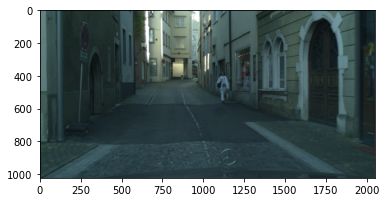

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


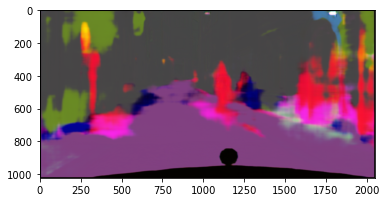

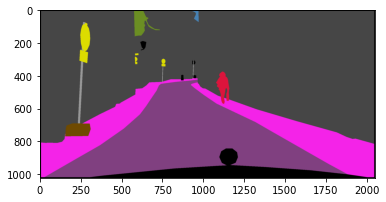

51
Epoch [2/10], Step [1/98], D_loss: -0.8034, G_loss: 3.0196
Epoch [2/10], Step [21/98], D_loss: -0.9174, G_loss: 2.5488
Epoch [2/10], Step [41/98], D_loss: -0.6358, G_loss: 3.0021
Epoch [2/10], Step [61/98], D_loss: -0.8329, G_loss: 2.1914
Epoch [2/10], Step [81/98], D_loss: -0.8598, G_loss: 5.1976
52
Epoch [3/10], Step [1/98], D_loss: -0.9256, G_loss: 2.2970
Epoch [3/10], Step [21/98], D_loss: -0.8781, G_loss: 3.3065
Epoch [3/10], Step [41/98], D_loss: -0.9441, G_loss: 1.3884
Epoch [3/10], Step [61/98], D_loss: -0.9116, G_loss: 2.0846
Epoch [3/10], Step [81/98], D_loss: -0.9529, G_loss: 2.5552
53
Epoch [4/10], Step [1/98], D_loss: -0.8937, G_loss: 2.3437
Epoch [4/10], Step [21/98], D_loss: -0.9093, G_loss: 2.5197
Epoch [4/10], Step [41/98], D_loss: -0.8999, G_loss: 2.8234
Epoch [4/10], Step [61/98], D_loss: -0.9306, G_loss: 2.1393
Epoch [4/10], Step [81/98], D_loss: -0.9142, G_loss: 4.1183
54
Epoch [5/10], Step [1/98], D_loss: -0.8713, G_loss: 2.3967
Epoch [5/10], Step [21/98], D_lo

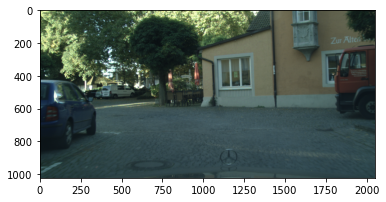

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


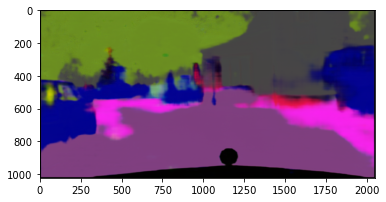

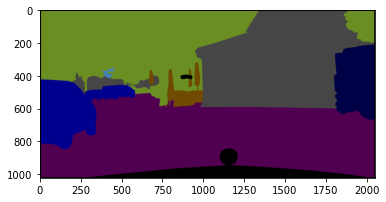

56
Epoch [7/10], Step [1/98], D_loss: -0.9386, G_loss: 3.1322
Epoch [7/10], Step [21/98], D_loss: -0.9091, G_loss: 1.9991
Epoch [7/10], Step [41/98], D_loss: -0.9474, G_loss: 2.9516
Epoch [7/10], Step [61/98], D_loss: -0.9605, G_loss: 4.1360
Epoch [7/10], Step [81/98], D_loss: -0.9636, G_loss: 2.1230
57
Epoch [8/10], Step [1/98], D_loss: -0.9708, G_loss: 2.4360
Epoch [8/10], Step [21/98], D_loss: -0.9589, G_loss: 2.1560
Epoch [8/10], Step [41/98], D_loss: -0.9738, G_loss: 2.3414
Epoch [8/10], Step [61/98], D_loss: -0.9440, G_loss: 3.4627
Epoch [8/10], Step [81/98], D_loss: -0.9362, G_loss: 2.6838
58
Epoch [9/10], Step [1/98], D_loss: -0.9382, G_loss: 2.0558
Epoch [9/10], Step [21/98], D_loss: -0.9382, G_loss: 3.1680
Epoch [9/10], Step [41/98], D_loss: -0.9665, G_loss: 2.9059
Epoch [9/10], Step [61/98], D_loss: -0.9533, G_loss: 3.2278
Epoch [9/10], Step [81/98], D_loss: -0.9720, G_loss: 3.1645
59
Epoch [10/10], Step [1/98], D_loss: -0.9789, G_loss: 3.0572
Epoch [10/10], Step [21/98], D_

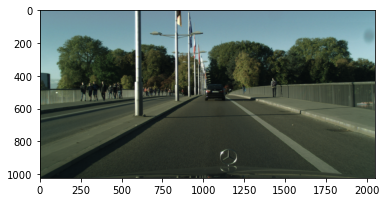

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


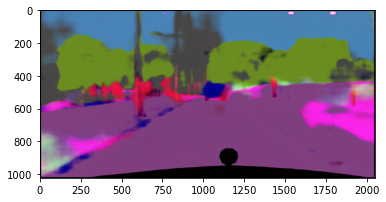

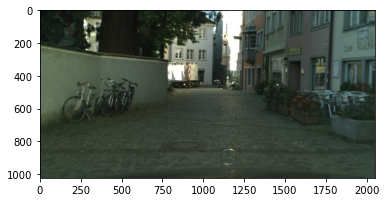

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


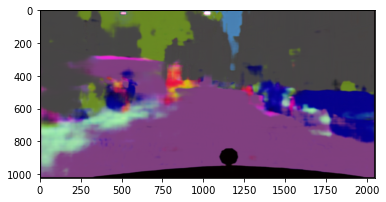

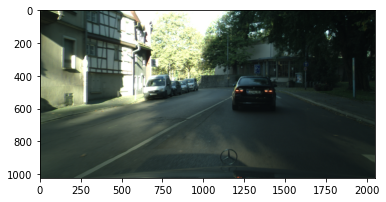

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


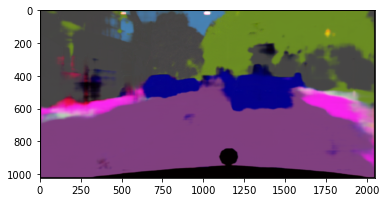

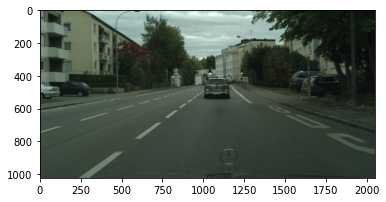

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


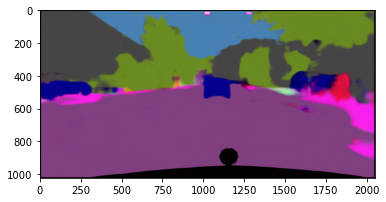

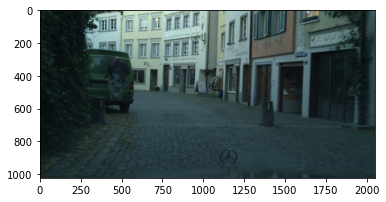

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


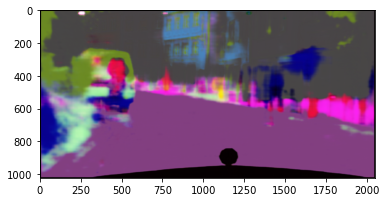

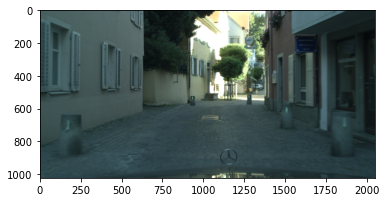

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


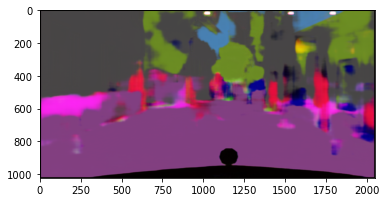

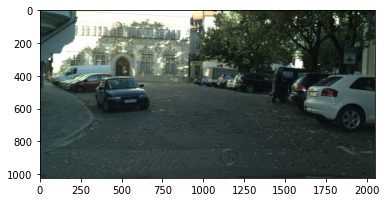

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


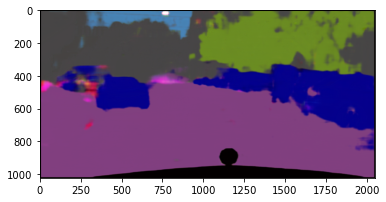

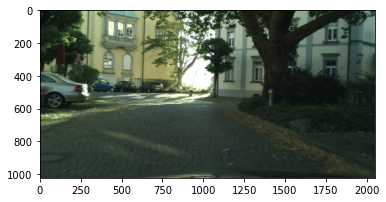

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


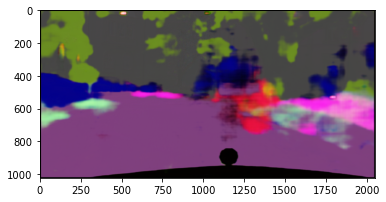

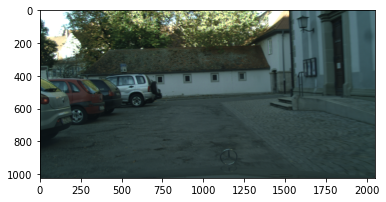

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


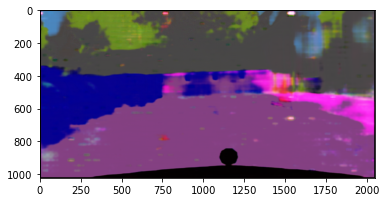

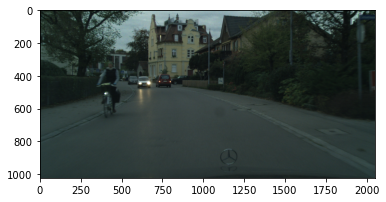

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


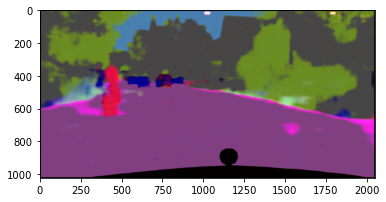

In [1]:
%run -i CGANS.py

torch.Size([3, 1024, 2048])